In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ipyleaflet import *
from tqdm import tqdm
from sklearn import linear_model, metrics
from sklearn.cluster import KMeans, DBSCAN
import cPickle as pickle
import time as tm
%pylab inline

D:\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


D:\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Widget', 'Polygon', 'Circle', 'Rectangle', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### 1. Загрузим данные за май

Загрузим наши данные с сайта TLC: www.nyc.gov/html/tlc/html/about/trip_record_data.shtml за май 2016 года:

In [2]:
data_trips = pd.read_csv ('yellow_tripdata_2016-05.csv', sep = ',',parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [3]:
data_trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


#### 2. Фильтрация данных

In [4]:
# Удаляем записи с нулевым количеством пассажиров, нулевым расстоянием  и нулевой длительностью:
data_trips = data_trips.drop(data_trips[(data_trips.passenger_count == 0) 
           | (data_trips.tpep_pickup_datetime == data_trips.tpep_dropoff_datetime) 
           | (data_trips.trip_distance == 0.0)].index)

In [5]:
# Удаляем записи координаты начала поездки которых не совпадают с границами Нью-Йорка
data_trips = data_trips.drop (data_trips[(data_trips.pickup_longitude <= -74.25559) | (data_trips.pickup_longitude >= -73.70001)
          |(data_trips.pickup_latitude <= 40.49612) | (data_trips.pickup_latitude >= 40.91553)].index)

#### 3. Агрегируем данные за май 2016 года по часам и областям

In [6]:
data1 = data_trips
# Отбросим минуты и секунды
data1.tpep_pickup_datetime = pd.Series(data1.tpep_pickup_datetime).dt.floor("H")
# Загрузим границы 2500 районов Нью-Йорка:
edges_data = pd.read_csv ('regions.csv', sep =';')
edges_long = sorted (set(edges_data.west.values) | set(edges_data.east.values))
edges_latit = sorted (set (edges_data.south.values) |set( edges_data.north.values))

In [7]:
# Напишем функцию которая создаст новый фрейм, где каждая запись будет 
# представлена количеством поездок в определенный час во всех районах Нью-Йорка:
def clustered (data, edges_long, edges_latit):
    if len(data) == 0:
        return np.array([0]*2500)
    else:
        cluster = scipy.stats.binned_statistic_2d (data.pickup_longitude, data.pickup_latitude, None,
                                                   'count', bins = [edges_long,edges_latit])
    return cluster.statistic.reshape(2500)

In [8]:
# Создадим новый фрейм с помощью функции написаной ранее
data2 = pd.DataFrame(columns = range(1,2501))
currentTime = data1.tpep_pickup_datetime[0]
endTime = max(data1.tpep_pickup_datetime)+datetime.timedelta(hours = 1)
delta_time = datetime.timedelta(hours = 1)
while currentTime != endTime:
    cluster = clustered (data1[data1.tpep_pickup_datetime == currentTime],edges_long,edges_latit)
    data2.loc[currentTime] = cluster
    currentTime += delta_time

# Week 4

#### 1. Прямоугольная таблица (по строкам время, по столбцам идентификатор зоны)

In [10]:
# Добавим данные за апрель
data_trips = pd.read_csv ('yellow_tripdata_2016-04.csv', sep = ',',parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
# Удаляем записи с нулевым количеством пассажиров, нулевым расстоянием  и нулевой длительностью:
data_trips = data_trips.drop(data_trips[(data_trips.passenger_count == 0) 
           | (data_trips.tpep_pickup_datetime == data_trips.tpep_dropoff_datetime) 
           | (data_trips.trip_distance == 0.0)].index)
# Удаляем записи координаты начала поездки которых не совпадают с границами Нью-Йорка
data_trips = data_trips.drop (data_trips[(data_trips.pickup_longitude <= -74.25559) | (data_trips.pickup_longitude >= -73.70001)
          |(data_trips.pickup_latitude <= 40.49612) | (data_trips.pickup_latitude >= 40.91553)].index)
# Отбросим минуты и секунды
data1 = data_trips
data1.tpep_pickup_datetime = pd.Series(data1.tpep_pickup_datetime).dt.floor("H")
# Создадим новый фрейм с помощью функции написаной ранее
data3 = pd.DataFrame(columns = range(1,2501))
currentTime = data1.tpep_pickup_datetime[0]
endTime = max(data1.tpep_pickup_datetime)+datetime.timedelta(hours = 1)
delta_time = datetime.timedelta(hours = 1)
while currentTime != endTime:
    cluster = clustered (data1[data1.tpep_pickup_datetime == currentTime],edges_long,edges_latit)
    data3.loc[currentTime] = cluster
    currentTime += delta_time

In [11]:
# Добавим данные за июнь
data_trips = pd.read_csv ('yellow_tripdata_2016-06.csv', sep = ',',parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
# Удаляем записи с нулевым количеством пассажиров, нулевым расстоянием  и нулевой длительностью:
data_trips = data_trips.drop(data_trips[(data_trips.passenger_count == 0) 
           | (data_trips.tpep_pickup_datetime == data_trips.tpep_dropoff_datetime) 
           | (data_trips.trip_distance == 0.0)].index)
# Удаляем записи координаты начала поездки которых не совпадают с границами Нью-Йорка
data_trips = data_trips.drop (data_trips[(data_trips.pickup_longitude <= -74.25559) | (data_trips.pickup_longitude >= -73.70001)
          |(data_trips.pickup_latitude <= 40.49612) | (data_trips.pickup_latitude >= 40.91553)].index)
# Отбросим минуты и секунды
data1 = data_trips
data1.tpep_pickup_datetime = pd.Series(data1.tpep_pickup_datetime).dt.floor("H")
# Создадим новый фрейм с помощью функции написаной ранее
data4 = pd.DataFrame(columns = range(1,2501))
currentTime = datetime.datetime.strptime('2016-06-01 00:00:00','%Y-%m-%d %H:%M:%S' )
endTime = max(data1.tpep_pickup_datetime)+datetime.timedelta(hours = 1)
delta_time = datetime.timedelta(hours = 1)
while currentTime != endTime:
    cluster = clustered (data1[data1.tpep_pickup_datetime == currentTime],edges_long,edges_latit)
    data4.loc[currentTime] = cluster
    currentTime += delta_time

In [12]:
# Выведем полученную таблицу
data3.head(2)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-04-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data4.head(2)

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-06-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2. Стандартизируем столбцы и отбросим все зоны, где среднее количество поездок < 5 в час

In [14]:
# Соберем индексы столбцов, в которых среднее количество поездок за май < 5 в час, и создадим новый фрейм, где соберем только информативные столбцы
index2drop = []
for i in range (0,2500):
    if float(data2.sum(axis =0)[i+1])/data2.shape[0] < 5:
        index2drop.append (i+1)

In [15]:
# Оставим в данных только зоны где в среднем в час поездок >=5
data_may = data2.drop(index2drop,axis =1)
data_april = data3.drop(index2drop,axis =1)
data_june = data4.drop(index2drop,axis =1)

In [17]:
data_april.shape

(720, 102)

In [18]:
# Нормализуем столбцы
data_april_norm = data_april.apply (lambda x: (x-x.mean())/x.std())
data_april_norm.head(1)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-04-01,-0.514661,-1.030331,-0.999111,-0.047033,-0.243696,0.09081,1.220538,1.179636,1.178311,0.316702,...,-0.234425,-0.923903,-0.790043,-0.311282,-0.922534,0.237346,0.515471,0.485838,0.853682,0.858107


#### 3. Кластеризуем географические зоны по значениям стандартизированных столбцов

In [19]:
#Транспонируем матрицу для дальнейшей кластеризации 
data_april_transp = data_april_norm.T

In [20]:
# Получим метки кластеров (метод KMeans)
clust_model = KMeans (4).fit(data_april_transp)
clust_model_predicts = clust_model.predict(data_april_transp)

In [21]:
# Сохраним модель, кластеризации
with open('clust_model.pkl', 'wb') as f:
    pickle.dump(clust_model, f)

In [22]:
# Загрузим модель модель, кластеризации
with open('clust_model.pkl', 'rb') as f:
    clust_model = pickle.load(f)

In [23]:
clust_model_predicts = clust_model.predict(data_april_transp)

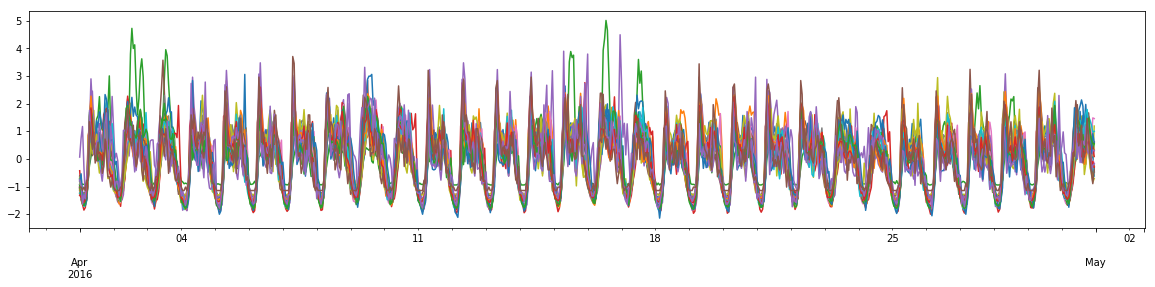

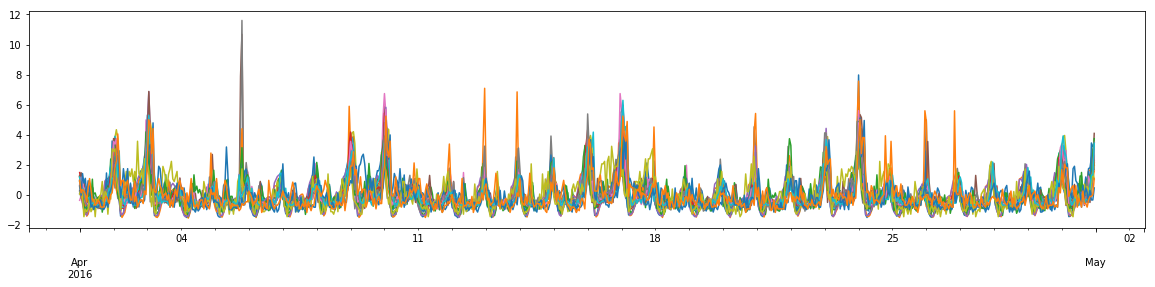

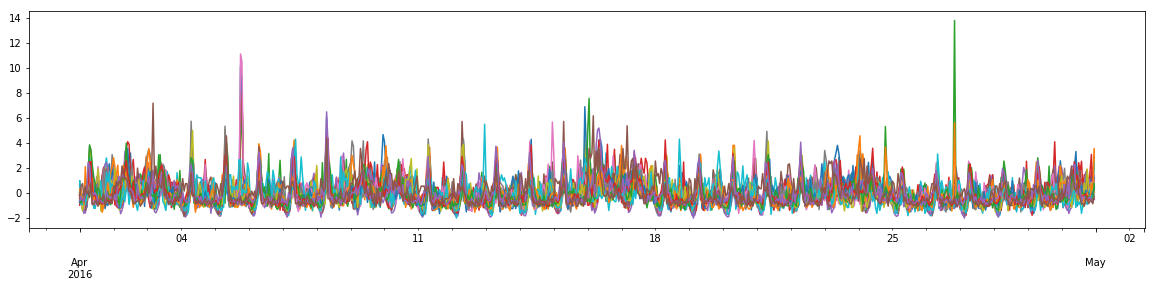

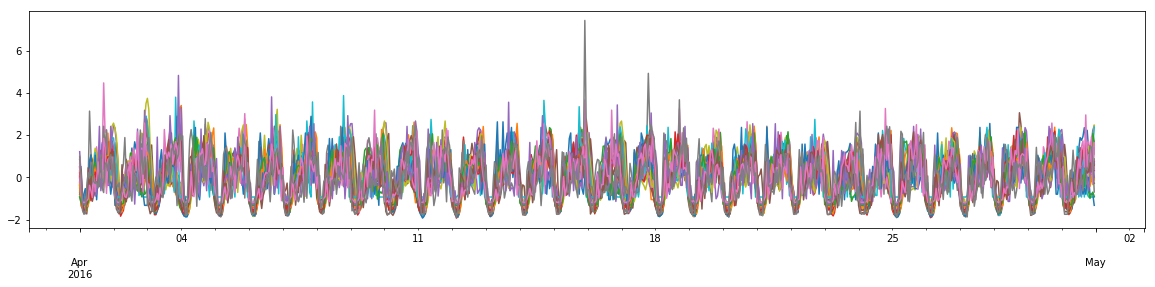

In [24]:
# Построим графики 4-х наших кластеров
for i in range (0, max(clust_model_predicts)+1):
    plt.figure (figsize = (20,4))
    for indexes in np.where (clust_model_predicts == i):
        for j in indexes:
            data_april_transp.iloc(0)[j].plot()
    plt.show()

In [25]:
# Посмотрим на полученные кластеры на карте
list_d3T = list(data_april)
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle
center = [40.7484831, -73.985585]
zoom = 11
m = Map(center=center, zoom=zoom)
colors = ['#0033FF', '#cd00ff', '#ffcd00', '#ff0032', '#32ff00']
for i in range (0, max(clust_model_predicts)+1):
    for indexes in np.where (clust_model_predicts == i):
        for j in indexes:
            rectangle = Rectangle(bounds=((edges_data.iloc[list_d3T[j]]['south'],edges_data.iloc[list_d3T[j]]['west']),
                                          (edges_data.iloc[list_d3T[j]]['north'], edges_data.iloc[list_d3T[j]]['east'])),
                                  stroke = False,fill_opacity = 0.6, fill_color = colors[i])
            m.add_layer(rectangle)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[40.7484831, -73.985585], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=[u'attribution', u'tile_size', u'min_zoom', u'max_zoom', u'detect_retina']), Rectangle(bounds=[(40.7142132, -74.0222464), (40.722601399999995, -74.0111348)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.722601399999995, -74.0222464), (40.7309896, -74.0111348)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.7645424, -74.0111348), (40.7729306, -74.0000232)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.756154200000005, -74.0000232), (40.7645424, -73.9889116)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.7729306, -74.0000232), (40.781318799999994, -73.9889116)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.781318799999994, -74.0000232), (40.789707, -73.9889116)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.781318799999994, -73.9889116), (40.789707, -73.9778)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.789707, -73.9889116), (40.798095200000006, -73.9778)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.7393778, -73.9778), (40.747766, -73.96668840000001)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.747766, -73.9778), (40.756154200000005, -73.96668840000001)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.781318799999994, -73.9778), (40.789707, -73.96668840000001)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u'stroke', u'no_clip', u'line_cap', u'smooth_factor', u'fill_opacity', u'pointer_events', u'line_join', u'fill'], stroke=False), Rectangle(bounds=[(40.789707, -73.9778), (40.798095200000006, -73.96668840000001)], fill_opacity=0.6, options=[u'opacity', u'fill_color', u'weight', u'class_name', u'dash_array', u'color', u

#### Кластеры сгрупировались осмысленно, видим отдельно зоны аэропортов, центра и окраины Нью-Йорка

#### 4. В каждом кластрере выберем ряд, являющийся центром данного кластера

In [26]:
principai_series = clust_model.cluster_centers_
distance = clust_model.transform(data_april_transp)

In [27]:
list_d3T = list(data_april)
min_index = [0,0,0,0]
min_value = distance[0]
for i in range (0, len(distance)):
    if distance[i][0] < min_value[0]:
        min_value[0] = distance[i][0]
        min_index[0] = i
    if distance[i][1] < min_value[1]:
        min_value[1] = distance[i][1]
        min_index[1] = i
    if distance[i][2] < min_value[2]:
        min_value[2] = distance[i][2]
        min_index[2] = i
    if distance[i][3] < min_value[3]:
        min_value[3] = distance[i][3]
        min_index[3] = i
real_index = [list_d3T[min_index[0]],list_d3T[min_index[1]],list_d3T[min_index[2]],list_d3T[min_index[3]]]
real_index

[1333L, 1326L, 1387L, 1233L]

#### 5. Для выбранных географических зон подберем на исходных рядах оптимальную структуру моделей 

In [34]:
from itertools import product
import warnings
Q = 2
q = 2
P = 2
p = 3
Qs = range (1, Q+1)
qs = range (1, q+1)
Ps= range (1, P+1)
ps = range (1,p+1)
D = 1
d = 1
parametrs = product (ps,qs,Ps,Qs)
parametrs_list = list(parametrs)

In [47]:
# Для каждого из главных рядов кластера построим регриссионные компоненты, а также мождель SARIMAX:
best_models = []
best_aic_arr = []
best_params = []
warnings.filterwarnings('ignore')
for i_x in tqdm(real_index):
    data_for_regress = pd.DataFrame (index = data_april.index )
    data_for_regress['Time'] = data_april.index
    data_for_regress['Trips'] = data_april[i_x]
    data_for_regress['week_day'] = data_for_regress.Time.apply(lambda x:  x.weekday())
    data_for_regress['hour'] = data_for_regress.Time.apply(lambda x:  x.hour)
    data_for_regress['sin_day'] = data_for_regress.Time.apply(lambda x: np.sin ((x.hour+2)*np.pi/12))
    data_for_regress['sin_week'] = data_for_regress.Time.apply(lambda x:  np.sin ((x.day)*np.pi/3.5))
    data_for_regress['peak_hours'] = 0
    data_for_regress['low_hours'] = 0
    data_for_regress.loc[((data_for_regress['hour']>= 19) & (data_for_regress['week_day'] <= 3)), 'peak_hours'] = 1
    data_for_regress.loc[data_for_regress['hour']<=7, 'low_hours'] = 1
    results = []
    best_aic = float('inf')
    for param in parametrs_list:
        try:
            model=sm.tsa.statespace.SARIMAX(data_for_regress.Trips,exog=data_for_regress[['sin_day','sin_week','peak_hours','low_hours']], order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
        except ValueError:
            #print ('wrong parametrs:', param)
            continue
        except LinAlgError:
            #print ('wrong parametrs:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    best_models.append (best_model)
    best_aic_arr.append(best_aic)
    best_params.append(best_param)
warnings.filterwarnings('default')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [19:16<00:00, 289.06s/it]


In [48]:
best_aic_arr

[5245.852443256933, 7972.007522035736, 5157.4313272799545, 8193.078943507215]

In [49]:
# Сохраним параметры моделей
best_models_params = [x.params for x in best_models]

In [50]:
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)
with open('best_model_params.pkl', 'wb') as f:
    pickle.dump(best_models_params, f)
with open('best_aic_arr.pkl', 'wb') as f:
    pickle.dump(best_aic_arr, f)

In [28]:
with open('best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)
with open('best_model_params.pkl', 'rb') as f:
    best_model_params = pickle.load(f)

#### 6. Построим для каждой из 102 географических зон предсказания  за период с 2016.04.30 23:00 до 2016.05.31 17:00 на 6 часов вперёд и посчитаем в ноутбуке ошибку прогноза 

In [29]:
# Собирем данные за апрель и май вместе
data_a_m = data_april.append(data_may)
# Создадим временой интервал с 30.04.2106 23:00 по 31.05.2016 17:00 
data_list = [datetime.datetime.strptime('2016-04-30 23:00:00','%Y-%m-%d %H:%M:%S' )+relativedelta(hours = x) for x in range (739)]

In [30]:
#для предсказаний меньше 0 поездок возвращаем 0
def minus_to_zero (x):
    if x > 0:
        return x
    else:
        return 0

In [ ]:
# Считаем Q с 30.04.2106 23:00 по 31.05.2016 17:00 
Q = 0
csv_to_kaggle = []
for i in tqdm(range(0,len(data_a_m.columns))):
    tm.sleep(20) # переживаю за перегрев процессора, поставлю отдых после каждой зоны
    data_for_regress = pd.DataFrame (index = data_a_m.index )
    data_for_regress['Time'] = data_a_m.index
    data_for_regress['Trips'] = data_a_m.iloc[:,i]
    data_for_regress['week_day'] = data_for_regress.Time.apply(lambda x:  x.weekday())
    data_for_regress['hour'] = data_for_regress.Time.apply(lambda x:  x.hour)
    data_for_regress['sin_day'] = data_for_regress.Time.apply(lambda x: np.sin ((x.hour+2)*np.pi/12))
    data_for_regress['sin_week'] = data_for_regress.Time.apply(lambda x:  np.sin ((x.day)*np.pi/3.5))
    data_for_regress['peak_hours'] = 0
    data_for_regress['low_hours'] = 0
    data_for_regress.loc[((data_for_regress['hour']>= 19) & (data_for_regress['week_day'] <= 3)), 'peak_hours'] = 1
    data_for_regress.loc[data_for_regress['hour']<=7, 'low_hours'] = 1
    number_of_clust = clust_model.predict([data_april.iloc[:,i]])
    param_to_sarimax = best_params[number_of_clust[0]]
    # для каждой из 102 временных зон тренеруем модель и считаем ошибку (обучать можно на данных 
    # за апрель и за май, тк в предсказании укажем dynamic=True, те данные для предсказание берутся только до time включительно)
    model_fitted = sm.tsa.statespace.SARIMAX(data_for_regress.Trips,exog=data_for_regress[['sin_day','sin_week','peak_hours','low_hours']],
                                             order=(param_to_sarimax[0], 1, param_to_sarimax[1]), 
                                             seasonal_order=(param_to_sarimax[2], 1, param_to_sarimax[3], 24)
                                            ).filter(best_models[number_of_clust[0]].params)
    for time in data_list:
        predicted_data = model_fitted.predict(time+relativedelta(hours = 1), time+relativedelta(hours = 6), dynamic=True)
        predicted_data = map (minus_to_zero, predicted_data)
        #for i_pred in range(1,7):
            #txt = str(data_a_m.columns[i]) + '_' + str(time.date()) + '_' + str(time.hour) + '_'+ str(i_pred) + ',' + str(int(round(predicted_data[i_pred-1])))
            #csv_to_kaggle.append(txt)
        Q += sum(fabs(predicted_data - data_for_regress.Trips[time+relativedelta(hours = 1):time +relativedelta(hours = 6)]))
Q = Q/452268
with open ('Q_may.txt','w') as f:
    f.write(Q)

In [5]:
# Выведем полученное значение ошибки:

print 'Q = ', Q

Q =  52.9566268907


#### Думаю значение можно уменьшить, если веса при регриссонных параметрах использовать индивидуальные для каждой зоны, а не одни на класстер

#### 6. Построим для каждой из 102 географических зон предсказания за период от 2016.05.31 23:00 до 2016.06.30 17:00 на 6 часов вперёд и посчитаем в ноутбуке ошибку прогноза 

In [41]:
# Собирем данные за май и июнь
data_m_j = data_may.append(data_june)
# Создадим временой интервал с 2016.05.31 23:00 до 2016.06.30 17:00 
data_list2 = [datetime.datetime.strptime('2016-05-31 23:00:00','%Y-%m-%d %H:%M:%S' )+relativedelta(hours = x) for x in range (715)]

In [46]:
Q = 0
csv_to_kaggle = []
for i in tqdm(range(0,len(data_m_j.columns))):
    tm.sleep(20)
    data_for_regress = pd.DataFrame (index = data_m_j.index )
    data_for_regress['Time'] = data_m_j.index
    data_for_regress['Trips'] = data_m_j.iloc[:,i]
    data_for_regress['week_day'] = data_for_regress.Time.apply(lambda x:  x.weekday())
    data_for_regress['hour'] = data_for_regress.Time.apply(lambda x:  x.hour)
    data_for_regress['sin_day'] = data_for_regress.Time.apply(lambda x: np.sin ((x.hour+2)*np.pi/12))
    data_for_regress['sin_week'] = data_for_regress.Time.apply(lambda x:  np.sin ((x.day)*np.pi/3.5))
    data_for_regress['peak_hours'] = 0
    data_for_regress['low_hours'] = 0
    data_for_regress.loc[((data_for_regress['hour']>= 19) & (data_for_regress['week_day'] <= 3)), 'peak_hours'] = 1
    data_for_regress.loc[data_for_regress['hour']<=7, 'low_hours'] = 1
    number_of_clust = clust_model.predict([data_april.iloc[:,i]])
    param_to_sarimax = best_params[number_of_clust[0]]
    model_fitted = sm.tsa.statespace.SARIMAX(data_for_regress.Trips,exog=data_for_regress[['sin_day','sin_week','peak_hours','low_hours']],
                                             order=(param_to_sarimax[0], 1, param_to_sarimax[1]), 
                                             seasonal_order=(param_to_sarimax[2], 1, param_to_sarimax[3], 24)
                                            ).filter(best_model_params[number_of_clust[0]])
    for time in data_list2:
        predicted_data = model_fitted.predict(time+relativedelta(hours = 1), time+relativedelta(hours = 6),dynamic=True)
        predicted_data = map (minus_to_zero, predicted_data)
        for i_pred in range(1,7):
            txt = str(data_a_m.columns[i]) + '_' + str(time.date()) + '_' + str(time.hour) + '_'+ str(i_pred) + ',' + str(int(round(predicted_data[i_pred-1])))
            csv_to_kaggle.append(txt)
        Q += sum(fabs(predicted_data - data_for_regress.Trips[time+relativedelta(hours = 1):time +relativedelta(hours = 6)]))
Q = Q/437580




  0%|                                                                                          | 0/102 [00:00<?, ?it/s]


  1%|▊                                                                              | 1/102 [01:49<3:04:50, 109.81s/it]


  2%|█▌                                                                             | 2/102 [03:39<3:03:11, 109.91s/it]


  3%|██▎                                                                            | 3/102 [05:29<3:01:15, 109.85s/it]


  4%|███                                                                            | 4/102 [07:17<2:58:44, 109.43s/it]


  5%|███▊                                                                           | 5/102 [09:07<2:56:58, 109.47s/it]


  6%|████▋                                                                          | 6/102 [10:57<2:55:18, 109.57s/it]


  7%|█████▍                                                                         | 7/102 [12:46<2:53:27, 109.55s/it]


  8%|██████▏         

IOError: [Errno 13] Permission denied: 'to_kaggle.csv'

In [52]:
with open ('to_kaggle.csv','w') as f:
    f.write('\n'.join(csv_to_kaggle))
with open ('Q_june.txt','w') as f:
    f.write(str(Q))

In [50]:
# Ссылка на лидербоард на kaggle
# https://www.kaggle.com/c/yellowtaxi/leaderboard (76 место Taksants Maksim=) )

437580